In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from os import walk
import pandas as pd
import tensorflow as tf
tf.config.run_functions_eagerly(True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
images= []
masks= []
for dirpath, dirnames, filenames in walk("/kaggle/input/lanelinedata/imgs"):
    for files in filenames :
        if(files.split(".")[-1]== "jpg"):
            images.append(os.path.join(dirpath, files))
                
for dirpath, dirnames, filenames in walk("/kaggle/input/lanelinedata/masks"):
    for files in filenames :
        if(files.split(".")[-1]== "png"):
            masks.append(os.path.join(dirpath, files))   

In [3]:
print("Number of Images:", len(images))
print("Number of Masks:", len(masks))

images= sorted(images)
masks= sorted(masks)

Number of Images: 18233
Number of Masks: 18233


In [4]:
img= plt.imread(images[0])
img.shape

(590, 1640, 3)

In [5]:
img= plt.imread(masks[0])
img.shape

(590, 1640)

In [103]:
img_h= img.shape[0]
img_w= img.shape[1]

In [6]:
data= pd.DataFrame(list(zip(images,masks)), columns= ["image_path", "mask_path"])
data

,image_path,mask_path
0,/kaggle/input/lanelinedata/imgs/06030819_0755....,/kaggle/input/lanelinedata/masks/06030819_0755...
1,/kaggle/input/lanelinedata/imgs/06030819_0755....,/kaggle/input/lanelinedata/masks/06030819_0755...
2,/kaggle/input/lanelinedata/imgs/06030819_0755....,/kaggle/input/lanelinedata/masks/06030819_0755...
3,/kaggle/input/lanelinedata/imgs/06030819_0755....,/kaggle/input/lanelinedata/masks/06030819_0755...
4,/kaggle/input/lanelinedata/imgs/06030819_0755....,/kaggle/input/lanelinedata/masks/06030819_0755...
...,...,...
18228,/kaggle/input/lanelinedata/imgs/06040314_1064....,/kaggle/input/lanelinedata/masks/06040314_1064...
18229,/kaggle/input/lanelinedata/imgs/06040314_1064....,/kaggle/input/lanelinedata/masks/06040314_1064...
18230,/kaggle/input/lanelinedata/imgs/06040314_1064....,/kaggle/input/lanelinedata/masks/06040314_1064...
18231,/kaggle/input/lanelinedata/imgs/06040314_1064....,/kaggle/input/lanelinedata/masks/06040314_1064...


In [7]:
def load_image(path):
    image= tf.io.read_file(path)
    image= tf.image.decode_jpeg(image, channels= 3)
    image= tf.image.resize(image, (256,256))
    return image
    
def load_masks(path):
    mask= tf.io.read_file(path)
    mask= tf.image.decode_png(mask, channels= 1)
    mask= tf.image.resize(mask, (256,256))
    return mask

def create_dataset(df):
    image_dataset= tf.data.Dataset.from_tensor_slices(df['image_path'])
    image_dataset= image_dataset.map(load_image, num_parallel_calls= tf.data.AUTOTUNE)
    image_dataset= image_dataset.apply(tf.data.experimental.ignore_errors())
    
    masks_dataset= tf.data.Dataset.from_tensor_slices(df['mask_path'])
    masks_dataset= masks_dataset.map(load_masks, num_parallel_calls= tf.data.AUTOTUNE)
    masks_dataset= masks_dataset.apply(tf.data.experimental.ignore_errors())
    
    dataset= tf.data.Dataset.zip((image_dataset, masks_dataset))
    return dataset

In [8]:
def get_dataset_partitions(dataset, dataset_size):
    train_split= 0.8
    val_split= 0.8
    test_split= 0.8
    shuffle_size= 10000
    
    dataset= dataset.shuffle(shuffle_size, seed= 12)
    train_size= int(train_split * dataset_size)
    val_size= int(val_split * dataset_size)    
    test_size= int(test_split * dataset_size)
    
    train_dataset= dataset.take(train_size)    
    val_dataset= dataset.skip(train_size).take(val_size)    
    test_dataset= dataset.skip(val_size).take(test_size)
    return train_dataset, val_dataset, test_dataset

In [9]:
dataset= create_dataset(data)
dataset_size= data.shape[0]
train_dataset, val_dataset, test_dataset=  get_dataset_partitions(dataset, dataset_size)

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [10]:
batch_size= 16
train_dataset= train_dataset.shuffle(buffer_size=1000).batch(batch_size)
val_dataset= val_dataset.batch(batch_size)
test_dataset= test_dataset.batch(batch_size)

In [11]:
def conv_block(input, num_filters):
    conv= tf.keras.layers.Conv2D(num_filters, 3, padding= "same")(input)
    conv= tf.keras.layers.BatchNormalization()(conv)
    conv= tf.keras.layers.Activation("relu")(conv)
    conv= tf.keras.layers.Conv2D(num_filters, 3, padding= "same")(conv)
    conv= tf.keras.layers.BatchNormalization()(conv)
    conv= tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip= conv_block(input, num_filters)
    pool= tf.keras.layers.MaxPool2D((2, 2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv= tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides= 2, padding= "same")(input)
    conv= tf.keras.layers.Concatenate()([up_conv, skip])
    conv= conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs= tf.keras.layers.Input(input_shape)

    skip1, pool1= encoder_block(inputs, 64)
    skip2, pool2= encoder_block(pool1, 128)
    skip3, pool3= encoder_block(pool2, 256)
    skip4, pool4= encoder_block(pool3, 512)

    bridge= conv_block(pool4, 1024)

    decode1= decoder_block(bridge, skip4, 512)
    decode2= decoder_block(decode1, skip3, 256)
    decode3= decoder_block(decode2, skip2, 128)
    decode4= decoder_block(decode3, skip1, 64)

    outputs= tf.keras.layers.Conv2D(1, 1, padding= "same", activation= "sigmoid")(decode4)

    model= tf.keras.models.Model(inputs, outputs, name= "U-Net")
    return model

unet_model= Unet((256,256,3))
unet_model.compile(optimizer= 'adam', loss= 'binary_crossentropy', metrics= ['accuracy'])
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0

In [12]:
history= unet_model.fit(train_dataset, 
                         validation_data= val_dataset,
                         batch_size = batch_size, 
                         epochs = 2)

Epoch 1/2
912/912 [==============================] - 1383s 1s/step - loss: -3.9283 - accuracy: 0.9572 - val_loss: -14.2297 - val_accuracy: 0.9280
Epoch 2/2
912/912 [==============================] - 1309s 1s/step - loss: -27.9967 - accuracy: 0.9515 - val_loss: -53.0438 - val_accuracy: 0.8439


In [20]:
images, masks= tuple(zip(*test_dataset))

In [99]:
nth_batch= 2
img1= np.array(images[nth_batch])
mask1= np.array(masks[nth_batch])
preds= unet_model.predict(images[nth_batch])

1/1 [==============================] - 0s 74ms/step


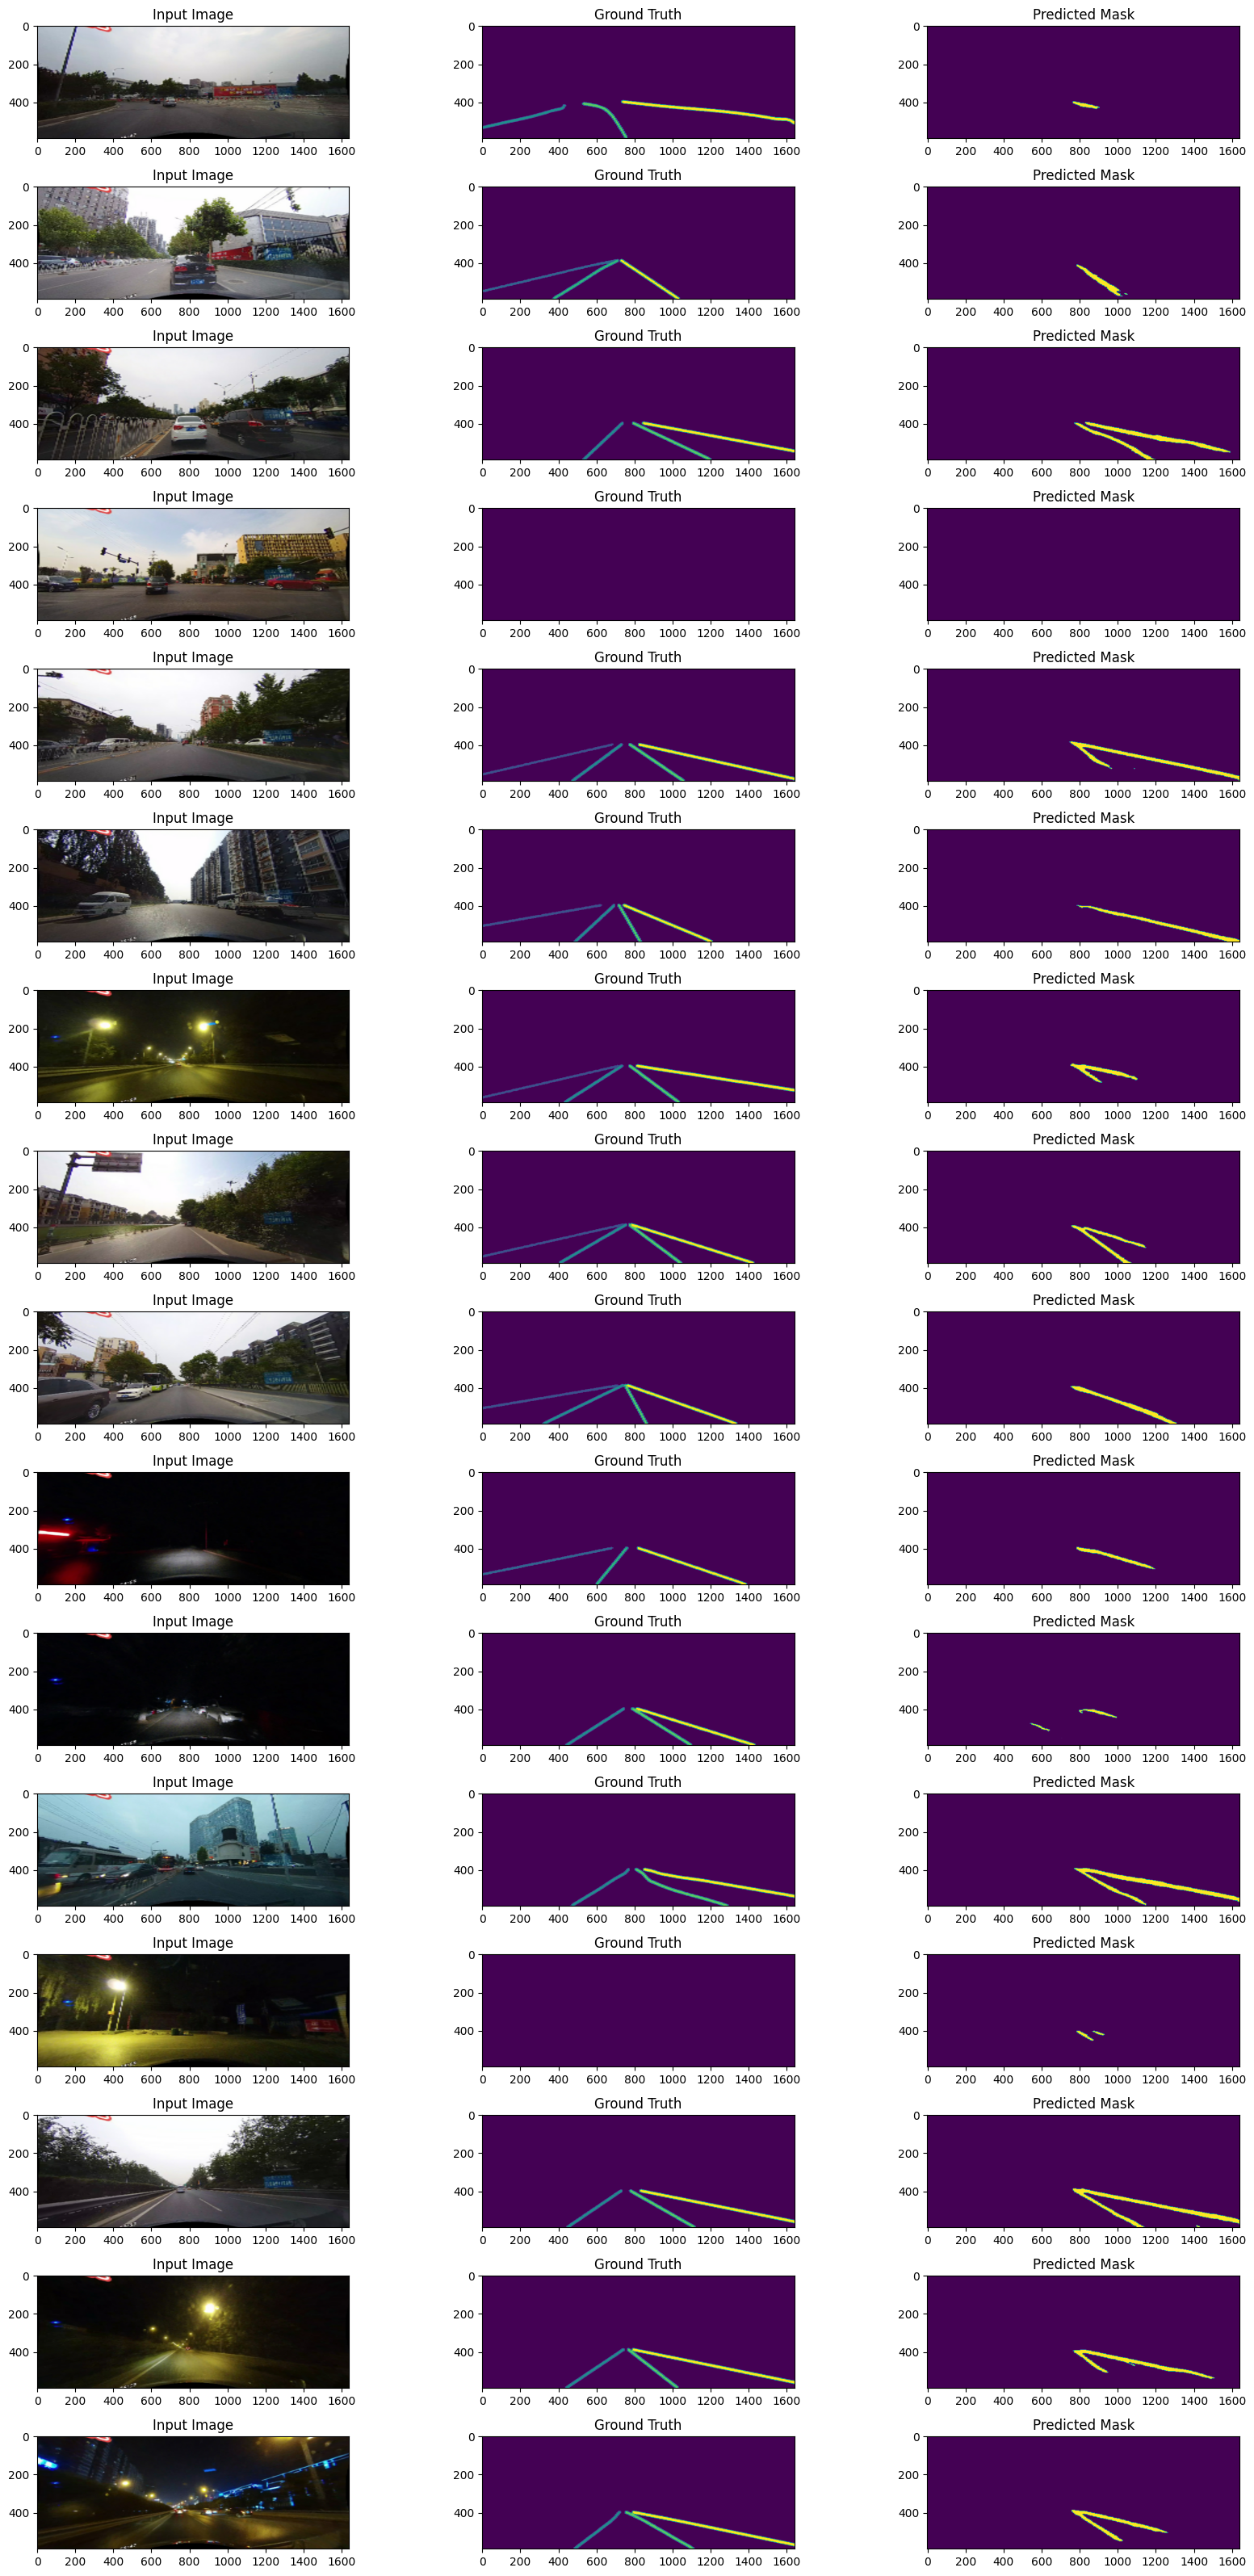

In [104]:
fig, axs= plt.subplots(batch_size, 3)
for i in range(batch_size):
    img= cv2.resize(img1[i],(img_w, img_h))
    plt.gcf().set_size_inches(18, 32)
    axs[i, 0].imshow(img.astype("uint8"))
    axs[i, 0].set_title("Input Image")
    
    mask= cv2.resize(mask1[i],(img_w, img_h))
    axs[i, 1].imshow(mask.astype("uint8"))
    axs[i, 1].set_title("Ground Truth")
    
    pred= cv2.resize(preds[i],(img_w, img_h))
    axs[i, 2].imshow(pred.astype("uint8"))
    axs[i, 2].set_title("Predicted Mask")
    
    fig.tight_layout(h_pad= 1, w_pad= 0.01)


plt.show()
